# Deutsch-Jozsa Algorithm
<hr></hr>

Deutsch's algorithm (named after David Deutsch) was the first demonstration of how quantum computing provides an advantage over classical computational methods [[Deutsch85](https://www.cs.princeton.edu/courses/archive/fall06/cos576/papers/deutsch85.pdf)]. The algorithm was later generalized for more than one qubit by David Deutsch and Ricahrd Jozsa [[Deutsch92](https://royalsocietypublishing.org/doi/abs/10.1098/rspa.1992.0167)], in what is today known as the [Deutsch-Jozsa algorithm](https://en.wikipedia.org/wiki/Deutsch%E2%80%93Jozsa_algorithm).

Even though these two algorithms do not solve problems of practical relevance, they are of indisputable historical importance, and laid the foundation for the development of all other quantum algorithms known today.

## 1. Deutsch's Algorithm

The formulation of the popularized version of Deutsch's algorithm was first presented by Richard Cleve, et. al. in 1997 [[Cleve97](https://arxiv.org/abs/quant-ph/9708016)]. It differs from Deutsch's original proposal in that it **deterministically** provides the right solution to what is known as Deutsch's problem in a single try, whereas a classical approach can only solve the problem correctly in one shot with $50 \%$ probability.

We will start by describing of how the algorithm works by casting it as a guessing game, followed by a formal definition in terms of a [quantum function evaluation](https://learnquantum.io/chapters/02_quantum_computing/02_05_quantum_blocks.html#quantum-function-evaluation).

### 1.1 General Description

A relatively intuitive way to understand Deutsch's problem is by setting it up in the form of a game. 

Imagine you are presented with a black box with two inputs and two outputs.

<img src="images/04_01_01_black_box.png" align = "center" width="700"/>

The box is "black" because you can't see what's inside; however, you are told that, with certainty, the box corresponds to one of four possible reversible circuits:

<img src="images/04_01_02_oracles.png" align = "center" width="750"/>

1. The first circuit is simple, both inputs go straight to the output.

2. The second circuit is similar, except the bottom input is always negated.

3. In the third circuit, the bottom output gets negated _if_ the top input is 1.

4. In the fourth circuit, the bottom output gets negated _if_ the top input is 0.

There are then two types of circuits: 

$\text{I}$. Those where the top and bottom paths are independent of each other (circuits 1 and 2),

$\text{II}$. Those where the top input can "influence" the bottom output (circuits 3 and 4).

To win the game, you have to correctly guess which of these two types of circuits is inside the box $(\text{I}$ or $\text{II}).$

#### 1.1.1 A Classical Strategy 

A first naïve strategy is to check if there is a combination of classical input values $x, y \in \{0, 1\}$ that provide different outputs for each of the two types of circuits. Now, since in all four circuits the top output is just a direct copy of the input $|x\rangle$, its value gives us no information about the type circuit inside the black box. We then only need to focus on what happens to the bottom output. Furthermore, given that the objective is to find if we have a box where the top path controls the bottom path (or not), the value that $y$ takes is irrelevant, so we can set it to $0$. We can then represent our black-box problem in terms of a single input $|x\rangle$ and a single output $|f(x)\rangle$:

<img src="images/04_01_03_black_box_simp.png" align = "center" width="270"/>

where we have a different $f(x)$ for each of the four possible circuits:

1. $f_1(x) = 0$. The output is always $|0\rangle,$ independent of the value of the input.

2. $f_2(x) = 1$. The output is always $|1\rangle,$ independent of the value of the input.

3. $f_3(x) = x$. The output is $|x\rangle;$ i.e., the same value as the input.

4. $f_4(x) = \bar{x}$. The output is $|\bar{x}\rangle;$ i.e., the opposite value of the input.

We can also summarize these four functions using Boolean tables:

<div style="display: flex; flex-wrap: wrap; gap: 20px;">

<div style="flex: 1;">

| $x$ | $f_1(x)$ |
| :-: |    :-:   |
| $0$ |    $0$   |
| $1$ |    $0$   |

    
</div>

<div style="flex: 1;">

| $x$ | $f_2(x)$ |
| :-: |    :-:   |
| $0$ |    $1$   |
| $1$ |    $1$   |
    
</div>

<div style="flex: 1;">

| $x$ | $f_3(x)$ |
| :-: |    :-:   |
| $0$ |    $0$   |
| $1$ |    $1$   |
    
</div>

<div style="flex: 1;">

| $x$ | $f_4(x)$ |
| :-: |    :-:   |
| $0$ |    $1$   |
| $1$ |    $0$   |
    
</div>

</div>

Given that, independent of the input, circuit 1 always provides a $0$ and circuit 2 always generates a $1$, we call these <span style="color:#a883f7">**constant**</span>. On the other hand, since circuits 3 and 4 generate both possible outputs ($0$ and $1$) depending on the input value, we call them <span style="color:#a883f7">**balanced**</span>. So our guessing game basically consists of figuring out if we have a constant or a balanced circuit.

Now, here is the culprit. Since we only get one chance at guessing which box we have, it is impossible for us to come up with a classical strategy to always win. If we were to always set our input to $|0\rangle$, we wouldn't be able to differentiate circuit 1 from circuit 3 because they both give an output of $|0\rangle$ (or circuit 2 from circuit 4 because they both give an output of $|1\rangle$). Similarly, if we were to always set our input to $|1\rangle$, we would never be able to tell circuit 1 and circuit 4 apart because they both give an output of $|0\rangle$ (or circuit 2 from circuit 2 because they both give an output of $|1\rangle$). Therefore, our probability of winning using this classical strategy is of only $50 \%$.

Let's simulate this by creating a function that generates a random black box, then taking a guess at which circuit we have based on the output, and checking the percentage of times we're right/wrong.

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

In [2]:
# Function that generates at random (with equal probability) each of the four possible circuits
def black_box():
    
    bb_num = np.random.randint(1,3) # Choose one of four possible black-box circuits
    
    qc_bb = QuantumCircuit(2, name='Black Box')
    match bb_num:
        case 1:                               # Option 1: Leave circuit empty
            pass           
        case 2:                               # Option 2: Add X gate to bottom qubit
            qc_bb.x(0)
        case 3:                               # Option 3: Add CX gate between top and bottom qubits
            qc_bb.cx(1,0,ctrl_state='1')
        case 4:                               # Option 4: Add C̅X gate between top and bottom qubits
            qc_bb.cx(1,0,ctrl_state='0')
            
    return qc_bb, bb_num                      # return black-box and corresponding number

In [3]:
# Implement circuit to solve Deutsch's problem classically
# Takes input value x and generates circuit with random black box and output meas
def deutsch_classic(x=0):
    bb, bb_num = black_box()  # generate random black-box
    
    qc = QuantumCircuit(2,1)
    if x: qc.x(1)             # if x = 1, add X gate to top qubit
    qc.append(bb,[0,1])       # append black box to circuit
    qc.measure(0,0)           # measure bottom qubit
    
    return qc, bb_num

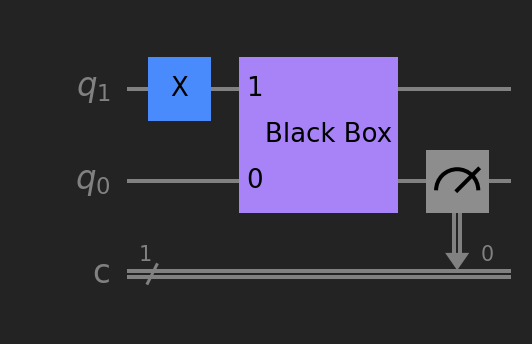

In [4]:
# Draw circuit to solve Deutsch's problem classically (input x = 1)
deutsch_classic(x=1)[0].draw()

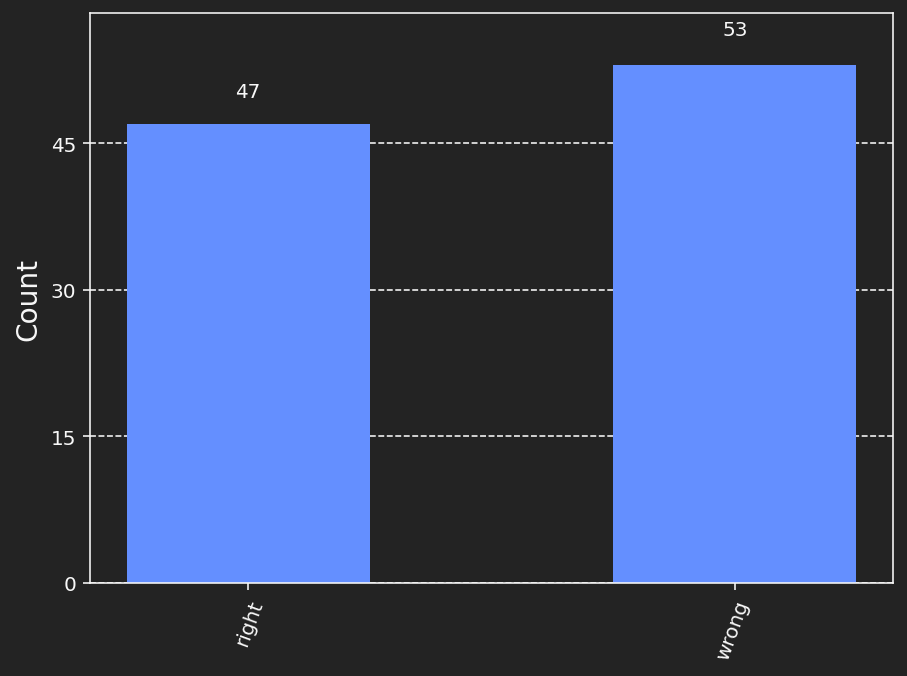

In [5]:
x = 1                            # Value of input x (can be 0 or 1)
n = 100                          # Number of times to play the game
guesses = {'right':0,'wrong':0}  # list of right/wrong guesses

simulator = AerSimulator()       # define simulator object

for i in range(n):
    qc, bb_num = deutsch_classic(x)
    
    qc_t = transpile(qc, simulator)
    job = simulator.run(qc_t, shots=1, memory=True)  # Run one simulation per black box 
                                                     # (we're only allowed to guess once)

    fx = job.result().get_memory()[0]        # extract output value of f(x)
     
    if (x == 0) and (fx == '0'):             # if x=0 and f(x)=0 we have either cir 1 or cir 3
        guess = np.random.choice([1,3])      # take random guess between circuit 1 or 3 (const or bal)
    
    elif (x == 0) and (fx == '1'):           # if x=0 and f(x)=1 we have either cir 2 or cir 4
        guess = np.random.choice([2,4])      # take random guess between circuit 2 or 4 (const or bal)
    
    elif (x == 1) and (fx == '0'):           # if x=1 and f(x)=0 we have either cir 1 or cir 4
        guess = np.random.choice([1,4])      # take random guess between circuit 1 or 4 (const or bal)
        
    elif (x == 1) and (fx == '1'):           # if x=1 and f(x)=1 we have either cir 2 or cir 3
        guess = np.random.choice([2,3])      # take random guess between circuit 2 or 3 (const or bal)
        
        
    if guess == bb_num:
        guesses['right'] += 1
    else:
        guesses['wrong'] += 1
        
plot_histogram(guesses)

As can be seen, we are equally likely to guess if we have the right or wrong circuit using this classical strategy. What Deutsch's algorithm enables, is the ability to **always** get the right answer in one try. But for this, we need to allow our inputs and outputs to take quantum values rather than taking only classical values.

#### 1.1.2 Using a Quantum Strategy

As mentioned before, Deutsch's problem can be summarized as trying to find if the circuit inside a black box is **constant** (which results when the top and bottom qubit are independent), or **balanced** (which occurs where we have a controlled $X$ gate from the top to the bottom qubit). Deutsch's algorithm exploits the fact that we can effectively construct a circuit around our black box that deterministically changes the output state of the **top** qubit based on having (or not) a controlled gate present. To understand how this is possible, let's compare circuits 1 and 3, both of which were indistinguishable in our classical approach when the input was $x = 0$. If we were to add Hadamard gates at the input and output of our black box: 

<img src="images/04_01_04_black_box_hadamard.png" align = "center" width="300"/>

we get the following equivalency for circuit 1:

<img src="images/04_01_05_cir1_equiv.png" align = "center" width="630"/>

and the following for circuit 3:

<img src="images/04_01_06_cir3_equiv.png" align = "center" width="630"/>

The result for circuit 1 is simple to explain: since the Hadamard gate is its own conjugate transpose (i.e., it is [Hermitian](https://en.wikipedia.org/wiki/Hermitian_matrix)), applying two Hadamard gates back to back to a qubit results in the identity operation (as we [pointed out](https://learnquantum.io/chapters/02_quantum_computing/02_03_single_qb_sys.html#refining-quantum-gates) before).

As for the result for circuit 3, this is exactly what we [previously observed](https://learnquantum.io/chapters/02_quantum_computing/02_05_quantum_blocks.html#kickback-in-action) for the phase-kickback effect acting on an $X$ gate! We can swap the control-to-target direction of a $CX$ gate by means of phase kickback.

Thus, if we now initialize the top qubit in state $|0\rangle$ and the bottom qubit in state $|1\rangle$, we are guaranteed to have the top output qubit in state $|0\rangle$ for circuit 1, and in state $|1\rangle$ for circuit 3, making them distinguishable. A similar analysis can be carried out for circuits 2 and 4, which again allows us to differentiate them from one another. 

So, in summary, by wrapping our black box with Hadamard gates, we are able to distinguish a **constant** circuit from a **balanced** circuit by measuring the top qubit, and checking if the result was $|0\rangle$ or $|1\rangle$, respectively.

Let us now perform a simulation similar to that of the classical strategy and compare the times we guess if we correctly identify if the circuit we have is constant or balanced.

In [6]:
# Implement circuit to solve Deutsch's problem using Deutsch's algorithm
def deutsch_quantum():
    bb, bb_num = black_box()  # generate random black-box
    
    qc = QuantumCircuit(2,1)
    qc.x(0)                   # Initialize bottom qubit to |1〉
    qc.barrier()
    qc.h([1,0])               # Hadamard before black box
    qc.append(bb,[0,1])       # append black box to circuit
    qc.h([1,0])               # Hadamard after black box
    qc.measure(1,0)           # measure top qubit
    
    return qc, bb_num

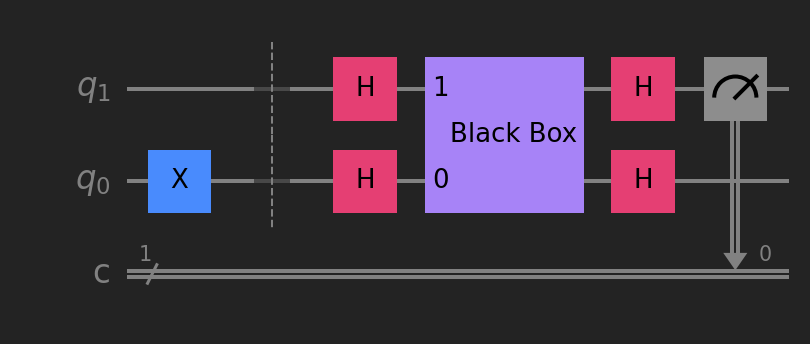

In [7]:
# Draw circuit for Deutsch's Algorithm
deutsch_quantum()[0].draw()

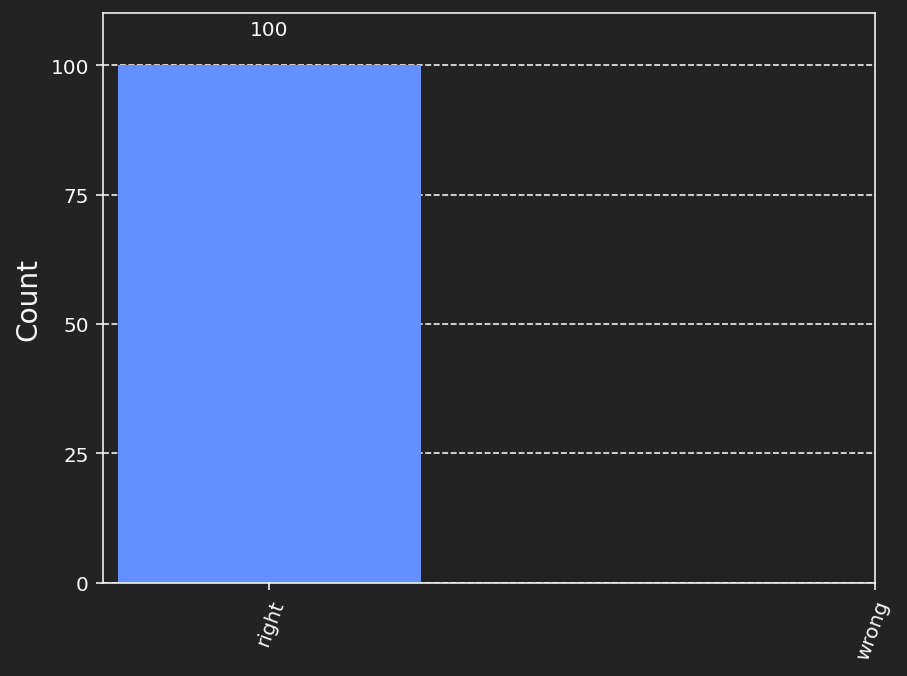

In [8]:
n = 100                           # Number of times to play the game
guesses = {'right':0,'wrong':0}   # list of right/wrong guesses

simulator = AerSimulator()        # define simulator object

for i in range(n):
    qc, bb_num = deutsch_quantum()                   # generate black box
    bb_type = 'c' if bb_num in (1, 2) else 'b'       # type of black box
    
    qc_t = transpile(qc, simulator)
    job = simulator.run(qc_t, shots=1, memory=True)  # Run one simulation per black box 
                                                     # (we're only allowed to guess once)

    top_qubit = job.result().get_memory()[0]         # extract output value of top qubit
    
    if top_qubit == '0':    # If top qubit is 0, we know circuit is constant (c)          
        guess = 'c'                    
    elif top_qubit == '1':  # If top qubit is 1, we know circuit is balanced (b)
        guess = 'b'
    
    if guess == bb_type:
        guesses['right'] += 1
    else:
        guesses['wrong'] += 1
        
plot_histogram(guesses)

As seen, Deutsch's algorithm provides a way to distinguish between the two different types of circuits every single time.

### 1.2 A more formal Explanation

In the previous section, we provided a general sketch of how Deutsch's algorithm works. Let's now formalize this by analyzing the circuit step by step.